In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 2

# Size of data split for testing
train_size = 0.9

In [ ]:
# Train-Test split
split = int(historical_sequences_norm.shape[0] * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [ ]:
# Load normalisers
normaliser = load('./normalisers/x_normaliser.joblib')
y_normaliser = load('./normalisers/y_normaliser.joblib')

In [ ]:
# Normalise data
train_norm = normaliser.transform(train)
test_norm = normaliser.transform(test)

##### Now I get indexes for chunks from 2 in 2 days (history doubles the backlook)

In [6]:
index = []

for i in range(days):
    index.append(np.arange(i,len(train),days))

In [7]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [9]:
# Normalised train chunks
X_train = np.array([train[ix].copy() for ix in ordered_index])
Y_train = np.array([train[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
Y_train = np.expand_dims(Y_train, -1)

In [10]:
# Delete those sequences that doesn't have a -th day in the results
X_train = X_train[:Y_train.shape[0]]

##### Same for test

In [ ]:
index = []

for i in range(days):
    index.append(np.arange(i,len(test),days))

In [ ]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [ ]:
# Normalised train chunks
X_test = np.array([test[ix].copy() for ix in ordered_index])
Y_test = np.array([test[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
Y_test = np.expand_dims(Y_test, -1)

In [ ]:
# Delete those sequences that doesn't have a -th day in the results
X_test = X_test[:Y_test.shape[0]]

# Model selection

##### Model constructor

In [15]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [16]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [17]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [18]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 2s 444us/step - loss: 0.0355 - val_loss: 0.0303
Epoch 2/24
3622/3622 [==============================] - 1s 184us/step - loss: 0.0238 - val_loss: 0.0036
Epoch 3/24
3622/3622 [==============================] - 1s 185us/step - loss: 0.0033 - val_loss: 7.7264e-04
Epoch 4/24
3622/3622 [==============================] - ETA: 0s - loss: 0.007 - 1s 185us/step - loss: 0.0071 - val_loss: 0.0033
Epoch 5/24
3622/3622 [==============================] - 1s 190us/step - loss: 0.0107 - val_loss: 0.0061
Epoch 6/24
3622/3622 [==============================] - 1s 185us/step - loss: 0.0321 - val_loss: 0.0082
Epoch 7/24
3622/3622 [==============================] - 1s 186us/step - loss: 0.0109 - val_loss: 0.0025
Epoch 8/24
3622/3622 [==============================] - 1s 188

3622/3622 [==============================] - 3s 869us/step - loss: 0.1115 - val_loss: 0.0014
Epoch 2/24
3622/3622 [==============================] - 2s 585us/step - loss: 0.0036 - val_loss: 0.0014
Epoch 3/24
3622/3622 [==============================] - 2s 585us/step - loss: 0.0030 - val_loss: 0.0033
Epoch 4/24
3622/3622 [==============================] - 2s 585us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/24
3622/3622 [==============================] - 2s 585us/step - loss: 0.0032 - val_loss: 0.0114
Epoch 6/24
3622/3622 [==============================] - 2s 586us/step - loss: 0.0074 - val_loss: 0.0033
Epoch 7/24
3622/3622 [==============================] - 2s 586us/step - loss: 0.0030 - val_loss: 0.0100
Epoch 8/24
3622/3622 [==============================] - 2s 582us/step - loss: 0.0075 - val_loss: 0.0190
Epoch 9/24
3622/3622 [==============================] - 2s 588us/step - loss: 0.0107 - val_loss: 0.0204
Epoch 10/24
3622/3622 [==============================] - 2s 585us/step - lo

3622/3622 [==============================] - 2s 526us/step - loss: 0.0103 - val_loss: 0.0048
Epoch 7/24
3622/3622 [==============================] - 2s 530us/step - loss: 0.0098 - val_loss: 0.0035
Epoch 8/24
3622/3622 [==============================] - 2s 529us/step - loss: 0.0078 - val_loss: 0.0176
Epoch 9/24
3622/3622 [==============================] - 2s 528us/step - loss: 0.0129 - val_loss: 0.0049
Epoch 10/24
3622/3622 [==============================] - 2s 525us/step - loss: 0.0024 - val_loss: 0.0201
Epoch 11/24
3622/3622 [==============================] - 2s 532us/step - loss: 0.0124 - val_loss: 0.0128
Epoch 12/24
3622/3622 [==============================] - 2s 529us/step - loss: 0.0032 - val_loss: 0.0059
Epoch 13/24
3622/3622 [==============================] - 2s 531us/step - loss: 0.0079 - val_loss: 0.0571
Epoch 14/24
3622/3622 [==============================] - 2s 527us/step - loss: 0.0086 - val_loss: 0.0043
Epoch 15/24
3622/3622 [==============================] - 2s 529us/step

Epoch 12/24
3622/3622 [==============================] - 1s 188us/step - loss: 0.0050 - val_loss: 0.0015
Epoch 13/24
3622/3622 [==============================] - 1s 184us/step - loss: 0.0054 - val_loss: 0.0026
Epoch 14/24
3622/3622 [==============================] - 1s 181us/step - loss: 0.0130 - val_loss: 0.0057
Epoch 15/24
3622/3622 [==============================] - 1s 183us/step - loss: 0.0071 - val_loss: 6.9919e-04
Epoch 16/24
3622/3622 [==============================] - 1s 181us/step - loss: 0.0117 - val_loss: 0.0070
Epoch 17/24
3622/3622 [==============================] - 1s 182us/step - loss: 0.0046 - val_loss: 6.3538e-04
Epoch 18/24
3622/3622 [==============================] - 1s 181us/step - loss: 0.0076 - val_loss: 0.0041
Epoch 19/24
3622/3622 [==============================] - 1s 183us/step - loss: 0.0036 - val_loss: 5.1420e-04
Epoch 20/24
3622/3622 [==============================] - 1s 182us/step - loss: 0.0046 - val_loss: 0.0026
Epoch 21/24
3622/3622 [====================

Epoch 21/24
3622/3622 [==============================] - 1s 195us/step - loss: 0.0022 - val_loss: 0.0046
Epoch 22/24
3622/3622 [==============================] - 1s 197us/step - loss: 0.0045 - val_loss: 0.0013
Epoch 23/24
3622/3622 [==============================] - 1s 198us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 24/24
3622/3622 [==============================] - 1s 193us/step - loss: 0.0035 - val_loss: 0.0029

GENERATION 2

Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 3s 877us/step - loss: 0.0555 - val_loss: 0.0181
Epoch 2/24
3622/3622 [==============================] - 2s 424us/step - loss: 0.0093 - val_loss: 0.0011
Epoch 3/24
3622/3622 [==============================] - 2s 425us/step - loss: 0.0042 - val_loss: 0.0101
Epoch 4/24
3622/3622 [==============================] - 2s 425us/step - loss: 0.0031 - val_loss: 0.0012
Epoch 5/24
3622/3622 [==============================] - 2s 425us/step - loss: 0.0022 - val_loss: 0.001

3622/3622 [==============================] - 1s 183us/step - loss: 0.0129 - val_loss: 0.0024
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 2s 662us/step - loss: 0.1422 - val_loss: 0.0441
Epoch 2/24
3622/3622 [==============================] - 1s 234us/step - loss: 0.0163 - val_loss: 0.0115
Epoch 3/24
3622/3622 [==============================] - 1s 239us/step - loss: 0.0077 - val_loss: 0.0012
Epoch 4/24
3622/3622 [==============================] - 1s 237us/step - loss: 0.0044 - val_loss: 0.0014
Epoch 5/24
3622/3622 [==============================] - 1s 234us/step - loss: 0.0027 - val_loss: 0.0011
Epoch 6/24
3622/3622 [==============================] - 1s 238us/step - loss: 0.0020 - val_loss: 7.3319e-04
Epoch 7/24
3622/3622 [==============================] - 1s 240us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 8/24
3622/3622 [==============================] - 1s 237us/step - loss: 0.0017 - val_loss: 9.3001e-04
Epoch 9/24
3622/3622

Epoch 9/24
3622/3622 [==============================] - 1s 380us/step - loss: 0.0023 - val_loss: 0.0133
Epoch 10/24
3622/3622 [==============================] - 1s 378us/step - loss: 0.0074 - val_loss: 0.0013
Epoch 11/24
3622/3622 [==============================] - 1s 380us/step - loss: 0.0030 - val_loss: 0.0022
Epoch 12/24
3622/3622 [==============================] - 1s 379us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 13/24
3622/3622 [==============================] - 1s 379us/step - loss: 0.0050 - val_loss: 0.0014
Epoch 14/24
3622/3622 [==============================] - 1s 384us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 15/24
3622/3622 [==============================] - 1s 379us/step - loss: 0.0071 - val_loss: 0.0011
Epoch 16/24
3622/3622 [==============================] - 1s 378us/step - loss: 0.0037 - val_loss: 0.0018
Epoch 17/24
3622/3622 [==============================] - 1s 379us/step - loss: 0.0113 - val_loss: 0.0019
Epoch 18/24
3622/3622 [==============================] -

3622/3622 [==============================] - 2s 478us/step - loss: 7.7164e-04 - val_loss: 7.8830e-04
Epoch 14/24
3622/3622 [==============================] - 2s 479us/step - loss: 7.5433e-04 - val_loss: 8.1752e-04
Epoch 15/24
3622/3622 [==============================] - 2s 480us/step - loss: 7.4344e-04 - val_loss: 8.1600e-04
Epoch 16/24
3622/3622 [==============================] - 2s 477us/step - loss: 7.3959e-04 - val_loss: 8.2877e-04
Epoch 17/24
3622/3622 [==============================] - 2s 480us/step - loss: 7.3147e-04 - val_loss: 9.8292e-04
Epoch 18/24
3622/3622 [==============================] - 2s 479us/step - loss: 7.6243e-04 - val_loss: 7.6592e-04
Epoch 19/24
3622/3622 [==============================] - 2s 477us/step - loss: 7.0378e-04 - val_loss: 8.5307e-04
Epoch 20/24
3622/3622 [==============================] - 2s 480us/step - loss: 7.3891e-04 - val_loss: 7.9222e-04
Epoch 21/24
3622/3622 [==============================] - 2s 476us/step - loss: 6.9758e-04 - val_loss: 6.5091

Epoch 19/24
3622/3622 [==============================] - 1s 184us/step - loss: 3.8051e-04 - val_loss: 5.9783e-04
Epoch 20/24
3622/3622 [==============================] - 1s 185us/step - loss: 4.1091e-04 - val_loss: 5.4835e-04
Epoch 21/24
3622/3622 [==============================] - 1s 184us/step - loss: 4.1040e-04 - val_loss: 4.6013e-04
Epoch 22/24
3622/3622 [==============================] - 1s 185us/step - loss: 4.1521e-04 - val_loss: 4.2976e-04
Epoch 23/24
3622/3622 [==============================] - 1s 183us/step - loss: 3.8134e-04 - val_loss: 3.7879e-04
Epoch 24/24
3622/3622 [==============================] - 1s 186us/step - loss: 3.5662e-04 - val_loss: 3.8276e-04
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 4s 1ms/step - loss: 0.0882 - val_loss: 0.0182
Epoch 2/24
3622/3622 [==============================] - 1s 203us/step - loss: 0.0100 - val_loss: 0.0045
Epoch 3/24
3622/3622 [==============================] - 1s 200us/step

3622/3622 [==============================] - 1s 198us/step - loss: 0.0638 - val_loss: 0.0141
Epoch 23/24
3622/3622 [==============================] - 1s 198us/step - loss: 0.0628 - val_loss: 0.0257
Epoch 24/24
3622/3622 [==============================] - 1s 197us/step - loss: 0.0595 - val_loss: 0.0158
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 4s 1ms/step - loss: 0.0379 - val_loss: 0.0029
Epoch 2/24
3622/3622 [==============================] - 1s 188us/step - loss: 0.0039 - val_loss: 0.0049
Epoch 3/24
3622/3622 [==============================] - 1s 188us/step - loss: 0.0032 - val_loss: 0.0071
Epoch 4/24
3622/3622 [==============================] - 1s 188us/step - loss: 0.0060 - val_loss: 0.0220
Epoch 5/24
3622/3622 [==============================] - 1s 189us/step - loss: 0.0071 - val_loss: 0.0114
Epoch 6/24
3622/3622 [==============================] - 1s 191us/step - loss: 0.0038 - val_loss: 0.0108
Epoch 7/24
3622/3622 [======

3622/3622 [==============================] - 1s 198us/step - loss: 0.0010 - val_loss: 7.1539e-04
Epoch 7/24
3622/3622 [==============================] - 1s 202us/step - loss: 7.9203e-04 - val_loss: 8.5501e-04
Epoch 8/24
3622/3622 [==============================] - 1s 198us/step - loss: 7.2780e-04 - val_loss: 8.0668e-04
Epoch 9/24
3622/3622 [==============================] - 1s 198us/step - loss: 6.9514e-04 - val_loss: 6.8089e-04
Epoch 10/24
3622/3622 [==============================] - 1s 197us/step - loss: 6.6648e-04 - val_loss: 8.4534e-04
Epoch 11/24
3622/3622 [==============================] - 1s 201us/step - loss: 6.4628e-04 - val_loss: 6.9372e-04
Epoch 12/24
3622/3622 [==============================] - 1s 200us/step - loss: 6.1925e-04 - val_loss: 6.5741e-04
Epoch 13/24
3622/3622 [==============================] - 1s 200us/step - loss: 6.0707e-04 - val_loss: 7.8707e-04
Epoch 14/24
3622/3622 [==============================] - 1s 198us/step - loss: 5.9062e-04 - val_loss: 6.4547e-04
Ep

Epoch 11/24
3622/3622 [==============================] - 1s 388us/step - loss: 0.0673 - val_loss: 0.0385
Epoch 12/24
3622/3622 [==============================] - 1s 395us/step - loss: 0.0658 - val_loss: 0.0170
Epoch 13/24
3622/3622 [==============================] - 1s 408us/step - loss: 0.0567 - val_loss: 0.0278
Epoch 14/24
3622/3622 [==============================] - 1s 409us/step - loss: 0.0699 - val_loss: 0.0476
Epoch 15/24
3622/3622 [==============================] - 1s 398us/step - loss: 0.0604 - val_loss: 0.0065
Epoch 16/24
3622/3622 [==============================] - 1s 386us/step - loss: 0.0321 - val_loss: 0.0076
Epoch 17/24
3622/3622 [==============================] - 1s 403us/step - loss: 0.0209 - val_loss: 0.0165
Epoch 18/24
3622/3622 [==============================] - 1s 406us/step - loss: 0.0177 - val_loss: 0.0091
Epoch 19/24
3622/3622 [==============================] - 2s 421us/step - loss: 0.0114 - val_loss: 0.0103
Epoch 20/24
3622/3622 [==============================] 

3622/3622 [==============================] - 2s 620us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 19/24
3622/3622 [==============================] - 2s 591us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 20/24
3622/3622 [==============================] - 2s 556us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 21/24
3622/3622 [==============================] - 2s 561us/step - loss: 0.0020 - val_loss: 0.0033
Epoch 22/24
3622/3622 [==============================] - 2s 593us/step - loss: 0.0020 - val_loss: 0.0033
Epoch 23/24
3622/3622 [==============================] - 2s 599us/step - loss: 0.0020 - val_loss: 0.0027
Epoch 24/24
3622/3622 [==============================] - 2s 586us/step - loss: 0.0018 - val_loss: 0.0024
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 8s 2ms/step - loss: 0.6988 - val_loss: 0.8588
Epoch 2/24
3622/3622 [==============================] - 2s 550us/step - loss: 0.2757 - val_loss: 0.0126
Epoch 3/24
3622/3622 [==

3622/3622 [==============================] - 2s 555us/step - loss: 0.0092 - val_loss: 0.0115
Epoch 24/24
3622/3622 [==============================] - 2s 556us/step - loss: 0.0066 - val_loss: 0.0250
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 8s 2ms/step - loss: 0.0524 - val_loss: 0.0013
Epoch 2/24
3622/3622 [==============================] - 2s 485us/step - loss: 0.0033 - val_loss: 0.0362
Epoch 3/24
3622/3622 [==============================] - 2s 483us/step - loss: 0.0103 - val_loss: 9.8509e-04
Epoch 4/24
3622/3622 [==============================] - 2s 481us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 5/24
3622/3622 [==============================] - 2s 483us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 6/24
3622/3622 [==============================] - 2s 483us/step - loss: 0.0032 - val_loss: 0.0237
Epoch 7/24
3622/3622 [==============================] - 2s 481us/step - loss: 0.0101 - val_loss: 0.0068
Epoch 8/24
3622/3622 [===

3622/3622 [==============================] - 1s 206us/step - loss: 0.0045 - val_loss: 0.0072
Epoch 3/24
3622/3622 [==============================] - 1s 205us/step - loss: 0.0038 - val_loss: 0.0010
Epoch 4/24
3622/3622 [==============================] - 1s 205us/step - loss: 7.1202e-04 - val_loss: 7.1498e-04
Epoch 5/24
3622/3622 [==============================] - 1s 205us/step - loss: 8.2401e-04 - val_loss: 0.0017
Epoch 6/24
3622/3622 [==============================] - 1s 206us/step - loss: 0.0059 - val_loss: 0.0149
Epoch 7/24
3622/3622 [==============================] - 1s 206us/step - loss: 0.0034 - val_loss: 6.1035e-04
Epoch 8/24
3622/3622 [==============================] - 1s 205us/step - loss: 6.5897e-04 - val_loss: 0.0016
Epoch 9/24
3622/3622 [==============================] - 1s 207us/step - loss: 7.2379e-04 - val_loss: 0.0020
Epoch 10/24
3622/3622 [==============================] - 1s 207us/step - loss: 7.9091e-04 - val_loss: 0.0014
Epoch 11/24
3622/3622 [=======================

3622/3622 [==============================] - 2s 680us/step - loss: 0.0037 - val_loss: 0.0552
Epoch 7/24
3622/3622 [==============================] - 2s 681us/step - loss: 0.0125 - val_loss: 0.0012
Epoch 8/24
3622/3622 [==============================] - 2s 677us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 9/24
3622/3622 [==============================] - 2s 680us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/24
3622/3622 [==============================] - 2s 682us/step - loss: 0.0040 - val_loss: 0.0012
Epoch 11/24
3622/3622 [==============================] - 2s 687us/step - loss: 0.0025 - val_loss: 0.0053
Epoch 12/24
3622/3622 [==============================] - 2s 673us/step - loss: 0.0064 - val_loss: 0.0170
Epoch 13/24
3622/3622 [==============================] - 2s 676us/step - loss: 0.0068 - val_loss: 0.0055
Epoch 14/24
3622/3622 [==============================] - 2s 675us/step - loss: 0.0038 - val_loss: 0.0045
Epoch 15/24
3622/3622 [==============================] - 2s 681us/step

3622/3622 [==============================] - 2s 448us/step - loss: 0.0693 - val_loss: 0.0225
Epoch 14/24
3622/3622 [==============================] - 2s 451us/step - loss: 0.0694 - val_loss: 0.0384
Epoch 15/24
3622/3622 [==============================] - 2s 445us/step - loss: 0.0691 - val_loss: 0.0472
Epoch 16/24
3622/3622 [==============================] - 2s 449us/step - loss: 0.0693 - val_loss: 0.0441
Epoch 17/24
3622/3622 [==============================] - 2s 448us/step - loss: 0.0691 - val_loss: 0.0345
Epoch 18/24
3622/3622 [==============================] - 2s 444us/step - loss: 0.0690 - val_loss: 0.0337
Epoch 19/24
3622/3622 [==============================] - 2s 448us/step - loss: 0.0689 - val_loss: 0.0386
Epoch 20/24
3622/3622 [==============================] - 2s 451us/step - loss: 0.0689 - val_loss: 0.0341
Epoch 21/24
3622/3622 [==============================] - 2s 447us/step - loss: 0.0689 - val_loss: 0.0288
Epoch 22/24
3622/3622 [==============================] - 2s 444us/s

3622/3622 [==============================] - 1s 208us/step - loss: 4.0444e-04 - val_loss: 4.3338e-04
Epoch 19/24
3622/3622 [==============================] - 1s 207us/step - loss: 3.9994e-04 - val_loss: 5.1418e-04
Epoch 20/24
3622/3622 [==============================] - 1s 209us/step - loss: 4.3285e-04 - val_loss: 3.9643e-04
Epoch 21/24
3622/3622 [==============================] - 1s 211us/step - loss: 3.6674e-04 - val_loss: 3.8844e-04
Epoch 22/24
3622/3622 [==============================] - 1s 210us/step - loss: 3.5730e-04 - val_loss: 5.3805e-04
Epoch 23/24
3622/3622 [==============================] - 1s 209us/step - loss: 3.9529e-04 - val_loss: 6.7236e-04
Epoch 24/24
3622/3622 [==============================] - 1s 207us/step - loss: 4.8933e-04 - val_loss: 3.9730e-04
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 10s 3ms/step - loss: 0.1391 - val_loss: 0.0357
Epoch 2/24
3622/3622 [==============================] - 1s 267us/step -

3622/3622 [==============================] - 1s 255us/step - loss: 0.0020 - val_loss: 8.9578e-04
Epoch 7/24
3622/3622 [==============================] - 1s 250us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 8/24
3622/3622 [==============================] - 1s 251us/step - loss: 0.0016 - val_loss: 0.0039
Epoch 9/24
3622/3622 [==============================] - 1s 252us/step - loss: 0.0016 - val_loss: 0.0030
Epoch 10/24
3622/3622 [==============================] - 1s 252us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 11/24
3622/3622 [==============================] - 1s 258us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 12/24
3622/3622 [==============================] - 1s 252us/step - loss: 0.0013 - val_loss: 0.0043
Epoch 13/24
3622/3622 [==============================] - 1s 251us/step - loss: 0.0013 - val_loss: 0.0045
Epoch 14/24
3622/3622 [==============================] - 1s 253us/step - loss: 0.0012 - val_loss: 0.0062
Epoch 15/24
3622/3622 [==============================] - 1s 252us/

3622/3622 [==============================] - 1s 273us/step - loss: 0.0016 - val_loss: 5.3607e-04
Epoch 13/24
3622/3622 [==============================] - 1s 270us/step - loss: 0.0014 - val_loss: 4.8898e-04
Epoch 14/24
3622/3622 [==============================] - 1s 277us/step - loss: 0.0014 - val_loss: 4.9819e-04
Epoch 15/24
3622/3622 [==============================] - 1s 274us/step - loss: 0.0013 - val_loss: 5.0061e-04
Epoch 16/24
3622/3622 [==============================] - 1s 273us/step - loss: 0.0013 - val_loss: 4.8063e-04
Epoch 17/24
3622/3622 [==============================] - 1s 275us/step - loss: 0.0012 - val_loss: 6.2999e-04
Epoch 18/24
3622/3622 [==============================] - 1s 276us/step - loss: 0.0012 - val_loss: 4.7594e-04
Epoch 19/24
3622/3622 [==============================] - 1s 271us/step - loss: 0.0012 - val_loss: 4.7275e-04
Epoch 20/24
3622/3622 [==============================] - 1s 282us/step - loss: 0.0011 - val_loss: 4.6969e-04
Epoch 21/24
3622/3622 [========

3622/3622 [==============================] - 2s 439us/step - loss: 0.0018 - val_loss: 0.0050
Epoch 19/24
3622/3622 [==============================] - 2s 447us/step - loss: 0.0017 - val_loss: 0.0074
Epoch 20/24
3622/3622 [==============================] - 2s 443us/step - loss: 0.0016 - val_loss: 0.0088
Epoch 21/24
3622/3622 [==============================] - 2s 442us/step - loss: 0.0017 - val_loss: 0.0050
Epoch 22/24
3622/3622 [==============================] - 2s 443us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 23/24
3622/3622 [==============================] - 2s 442us/step - loss: 0.0019 - val_loss: 0.0056
Epoch 24/24
3622/3622 [==============================] - 2s 443us/step - loss: 0.0016 - val_loss: 0.0109
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 14s 4ms/step - loss: 0.0952 - val_loss: 0.0136
Epoch 2/24
3622/3622 [==============================] - 2s 443us/step - loss: 0.0142 - val_loss: 0.0048
Epoch 3/24
3622/3622 [=

3622/3622 [==============================] - 2s 443us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 24/24
3622/3622 [==============================] - 2s 469us/step - loss: 0.0016 - val_loss: 0.0016
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 16s 4ms/step - loss: 2.0093 - val_loss: 1.8423
Epoch 2/24
3622/3622 [==============================] - 2s 460us/step - loss: 1.2089 - val_loss: 1.1222
Epoch 3/24
3622/3622 [==============================] - 2s 461us/step - loss: 0.6896 - val_loss: 0.6566
Epoch 4/24
3622/3622 [==============================] - 2s 476us/step - loss: 0.3763 - val_loss: 0.3654
Epoch 5/24
3622/3622 [==============================] - 2s 450us/step - loss: 0.2010 - val_loss: 0.1968
Epoch 6/24
3622/3622 [==============================] - 2s 455us/step - loss: 0.1163 - val_loss: 0.1059
Epoch 7/24
3622/3622 [==============================] - 2s 458us/step - loss: 0.0815 - val_loss: 0.0604
Epoch 8/24
3622/3622 [======

Epoch 2/24
3622/3622 [==============================] - 1s 241us/step - loss: 0.0167 - val_loss: 0.0151
Epoch 3/24
3622/3622 [==============================] - 1s 240us/step - loss: 0.0062 - val_loss: 0.0060
Epoch 4/24
3622/3622 [==============================] - 1s 236us/step - loss: 0.0032 - val_loss: 0.0024
Epoch 5/24
3622/3622 [==============================] - 1s 235us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/24
3622/3622 [==============================] - 1s 236us/step - loss: 9.6492e-04 - val_loss: 7.9999e-04
Epoch 7/24
3622/3622 [==============================] - 1s 239us/step - loss: 8.5452e-04 - val_loss: 7.7747e-04
Epoch 8/24
3622/3622 [==============================] - 1s 242us/step - loss: 7.9758e-04 - val_loss: 0.0010
Epoch 9/24
3622/3622 [==============================] - 1s 237us/step - loss: 7.5950e-04 - val_loss: 7.3852e-04
Epoch 10/24
3622/3622 [==============================] - 1s 234us/step - loss: 7.1347e-04 - val_loss: 7.3673e-04
Epoch 11/24
3622/3622 [====

Epoch 15/24
3622/3622 [==============================] - 2s 442us/step - loss: nan - val_loss: nan
Epoch 16/24
3622/3622 [==============================] - 2s 441us/step - loss: nan - val_loss: nan
Epoch 17/24
3622/3622 [==============================] - 2s 447us/step - loss: nan - val_loss: nan
Epoch 18/24
3622/3622 [==============================] - 2s 440us/step - loss: nan - val_loss: nan
Epoch 19/24
3622/3622 [==============================] - 2s 441us/step - loss: nan - val_loss: nan
Epoch 20/24
3622/3622 [==============================] - 2s 442us/step - loss: nan - val_loss: nan
Epoch 21/24
3622/3622 [==============================] - 2s 439us/step - loss: nan - val_loss: nan
Epoch 22/24
3622/3622 [==============================] - 2s 444us/step - loss: nan - val_loss: nan
Epoch 23/24
3622/3622 [==============================] - 2s 440us/step - loss: nan - val_loss: nan
Epoch 24/24
3622/3622 [==============================] - 2s 444us/step - loss: nan - val_loss: nan
Train on 3

Epoch 23/24
3622/3622 [==============================] - 1s 216us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 24/24
3622/3622 [==============================] - 1s 216us/step - loss: 0.0016 - val_loss: 0.0015
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 17s 5ms/step - loss: 1.4261 - val_loss: 0.0018
Epoch 2/24
3622/3622 [==============================] - 1s 218us/step - loss: 0.0082 - val_loss: 8.7725e-04
Epoch 3/24
3622/3622 [==============================] - 1s 216us/step - loss: 0.0051 - val_loss: 9.1594e-04
Epoch 4/24
3622/3622 [==============================] - 1s 220us/step - loss: 0.0043 - val_loss: 0.0017
Epoch 5/24
3622/3622 [==============================] - 1s 218us/step - loss: 0.0040 - val_loss: 0.0021
Epoch 6/24
3622/3622 [==============================] - 1s 217us/step - loss: 0.0035 - val_loss: 0.0011
Epoch 7/24
3622/3622 [==============================] - 1s 217us/step - loss: 0.0035 - val_loss: 0.0027
Epoch 8/

3622/3622 [==============================] - 1s 215us/step - loss: 0.0063 - val_loss: 0.0040
Epoch 5/24
3622/3622 [==============================] - 1s 216us/step - loss: 0.0041 - val_loss: 0.0017
Epoch 6/24
3622/3622 [==============================] - 1s 216us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 7/24
3622/3622 [==============================] - 1s 215us/step - loss: 0.0026 - val_loss: 9.0328e-04
Epoch 8/24
3622/3622 [==============================] - 1s 215us/step - loss: 0.0026 - val_loss: 0.0018
Epoch 9/24
3622/3622 [==============================] - 1s 216us/step - loss: 0.0023 - val_loss: 8.9126e-04
Epoch 10/24
3622/3622 [==============================] - 1s 214us/step - loss: 0.0022 - val_loss: 9.2276e-04
Epoch 11/24
3622/3622 [==============================] - 1s 215us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 12/24
3622/3622 [==============================] - 1s 217us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 13/24
3622/3622 [==============================] - 1s 

Epoch 13/24
3622/3622 [==============================] - 2s 494us/step - loss: 0.0015 - val_loss: 0.0034
Epoch 14/24
3622/3622 [==============================] - 2s 498us/step - loss: 0.0015 - val_loss: 0.0026
Epoch 15/24
3622/3622 [==============================] - 2s 495us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 16/24
3622/3622 [==============================] - 2s 495us/step - loss: 0.0015 - val_loss: 0.0028
Epoch 17/24
3622/3622 [==============================] - 2s 495us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 18/24
3622/3622 [==============================] - 2s 500us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 19/24
3622/3622 [==============================] - 2s 492us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 20/24
3622/3622 [==============================] - 2s 494us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 21/24
3622/3622 [==============================] - 2s 494us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 22/24
3622/3622 [==============================] 

Epoch 18/24
3622/3622 [==============================] - 2s 445us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 19/24
3622/3622 [==============================] - 2s 445us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 20/24
3622/3622 [==============================] - 2s 444us/step - loss: 0.0023 - val_loss: 0.0015
Epoch 21/24
3622/3622 [==============================] - 2s 446us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 22/24
3622/3622 [==============================] - 2s 445us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 23/24
3622/3622 [==============================] - 2s 445us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 24/24
3622/3622 [==============================] - 2s 448us/step - loss: 0.0020 - val_loss: 0.0019
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 24s 7ms/step - loss: 0.2335 - val_loss: 0.0400
Epoch 2/24
3622/3622 [==============================] - 2s 500us/step - loss: 0.0698 - val_loss: 0.0330
Epoch 3/24


3622/3622 [==============================] - 26s 7ms/step - loss: nan - val_loss: nan
Epoch 2/24
3622/3622 [==============================] - 2s 580us/step - loss: nan - val_loss: nan
Epoch 3/24
3622/3622 [==============================] - 2s 580us/step - loss: nan - val_loss: nan
Epoch 4/24
3622/3622 [==============================] - 2s 578us/step - loss: nan - val_loss: nan
Epoch 5/24
3622/3622 [==============================] - 2s 580us/step - loss: nan - val_loss: nan
Epoch 6/24
3622/3622 [==============================] - 2s 576us/step - loss: nan - val_loss: nan
Epoch 7/24
3622/3622 [==============================] - 2s 583us/step - loss: nan - val_loss: nan
Epoch 8/24
3622/3622 [==============================] - 2s 579us/step - loss: nan - val_loss: nan
Epoch 9/24
3622/3622 [==============================] - 2s 583us/step - loss: nan - val_loss: nan
Epoch 10/24
3622/3622 [==============================] - 2s 579us/step - loss: nan - val_loss: nan
Epoch 11/24
3622/3622 [========

Epoch 16/24
3622/3622 [==============================] - 1s 271us/step - loss: nan - val_loss: nan
Epoch 17/24
3622/3622 [==============================] - 1s 273us/step - loss: nan - val_loss: nan
Epoch 18/24
3622/3622 [==============================] - 1s 276us/step - loss: nan - val_loss: nan
Epoch 19/24
3622/3622 [==============================] - 1s 272us/step - loss: nan - val_loss: nan
Epoch 20/24
3622/3622 [==============================] - 1s 273us/step - loss: nan - val_loss: nan
Epoch 21/24
3622/3622 [==============================] - 1s 271us/step - loss: nan - val_loss: nan
Epoch 22/24
3622/3622 [==============================] - 1s 271us/step - loss: nan - val_loss: nan
Epoch 23/24
3622/3622 [==============================] - 1s 271us/step - loss: nan - val_loss: nan
Epoch 24/24
3622/3622 [==============================] - 1s 271us/step - loss: nan - val_loss: nan
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 27s 7m

3622/3622 [==============================] - 31s 8ms/step - loss: 0.1352 - val_loss: 0.0012
Epoch 2/24
3622/3622 [==============================] - 2s 585us/step - loss: 0.0066 - val_loss: 0.0243
Epoch 3/24
3622/3622 [==============================] - 2s 583us/step - loss: 0.0059 - val_loss: 0.0032
Epoch 4/24
3622/3622 [==============================] - 2s 584us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 5/24
3622/3622 [==============================] - 2s 585us/step - loss: 0.0032 - val_loss: 0.0139
Epoch 6/24
3622/3622 [==============================] - 2s 590us/step - loss: 0.0088 - val_loss: 9.9150e-04
Epoch 7/24
3622/3622 [==============================] - 2s 588us/step - loss: 0.0023 - val_loss: 9.4703e-04
Epoch 8/24
3622/3622 [==============================] - 2s 590us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 9/24
3622/3622 [==============================] - 2s 587us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/24
3622/3622 [==============================] - 2s 589us/st

3622/3622 [==============================] - 1s 228us/step - loss: 0.0072 - val_loss: 0.0027
Epoch 7/24
3622/3622 [==============================] - 1s 228us/step - loss: 0.0082 - val_loss: 0.0065
Epoch 8/24
3622/3622 [==============================] - 1s 227us/step - loss: 0.0083 - val_loss: 0.0025
Epoch 9/24
3622/3622 [==============================] - 1s 234us/step - loss: 0.0049 - val_loss: 0.0448
Epoch 10/24
3622/3622 [==============================] - 1s 226us/step - loss: 0.0084 - val_loss: 0.0131
Epoch 11/24
3622/3622 [==============================] - 1s 227us/step - loss: 0.0065 - val_loss: 0.0099
Epoch 12/24
3622/3622 [==============================] - 1s 228us/step - loss: 0.0055 - val_loss: 0.0129
Epoch 13/24
3622/3622 [==============================] - 1s 227us/step - loss: 0.0067 - val_loss: 0.0076
Epoch 14/24
3622/3622 [==============================] - 1s 227us/step - loss: 0.0047 - val_loss: 0.0270
Epoch 15/24
3622/3622 [==============================] - 1s 232us/step

3622/3622 [==============================] - 1s 230us/step - loss: 6.3139e-04 - val_loss: 6.3805e-04
Epoch 14/24
3622/3622 [==============================] - 1s 230us/step - loss: 5.8897e-04 - val_loss: 5.9682e-04
Epoch 15/24
3622/3622 [==============================] - 1s 243us/step - loss: 5.4361e-04 - val_loss: 5.6071e-04
Epoch 16/24
3622/3622 [==============================] - 1s 230us/step - loss: 5.0674e-04 - val_loss: 5.5268e-04
Epoch 17/24
3622/3622 [==============================] - 1s 229us/step - loss: 4.8719e-04 - val_loss: 5.4780e-04
Epoch 18/24
3622/3622 [==============================] - 1s 228us/step - loss: 4.7875e-04 - val_loss: 5.5457e-04
Epoch 19/24
3622/3622 [==============================] - 1s 230us/step - loss: 4.5393e-04 - val_loss: 4.8080e-04
Epoch 20/24
3622/3622 [==============================] - 1s 230us/step - loss: 4.2615e-04 - val_loss: 4.6546e-04
Epoch 21/24
3622/3622 [==============================] - 1s 230us/step - loss: 4.1024e-04 - val_loss: 4.1613

Epoch 21/24
3622/3622 [==============================] - 2s 523us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 22/24
3622/3622 [==============================] - 2s 521us/step - loss: 0.0015 - val_loss: 0.0026
Epoch 23/24
3622/3622 [==============================] - 2s 523us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 24/24
3622/3622 [==============================] - 2s 526us/step - loss: 0.0014 - val_loss: 0.0023
Train on 3622 samples, validate on 403 samples
Epoch 1/24
3622/3622 [==============================] - 37s 10ms/step - loss: 0.1316 - val_loss: 0.0026
Epoch 2/24
3622/3622 [==============================] - 2s 522us/step - loss: 0.0174 - val_loss: 0.0189
Epoch 3/24
3622/3622 [==============================] - 2s 523us/step - loss: 0.0080 - val_loss: 0.0065
Epoch 4/24
3622/3622 [==============================] - 2s 526us/step - loss: 0.0041 - val_loss: 0.0017
Epoch 5/24
3622/3622 [==============================] - 2s 523us/step - loss: 0.0027 - val_loss: 0.0039
Epoch 6/24
36

In [19]:
best_models[0][1].history['val_loss']

[0.007785015739500523,
 0.0008450688910670578,
 0.002771921455860138,
 0.0030496995896101,
 0.0006214528111740947,
 0.0006552666309289634,
 0.0008440040401183069,
 0.0006251477170735598,
 0.000620624516159296,
 0.0007459184271283448,
 0.000617238343693316,
 0.0006313800113275647,
 0.0005857678479515016,
 0.0005334086017683148,
 0.0005036257789470255,
 0.00046905167982913554,
 0.000427537685027346,
 0.0004048815171699971,
 0.0003899291914422065,
 0.0003846220497507602,
 0.0004422336060088128,
 0.00039258724427782,
 0.00036199085297994316,
 0.0003609123232308775]

In [20]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
lstmsize: 126
density: 154
optimizer: adam
full_density: True
activation: relu
shuffle: True
twice: False


In [21]:
best_models[0][0].summary()

Model: "sequential_156"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_231 (LSTM)              (None, 126)               66528     
_________________________________________________________________
dense_783 (Dense)            (None, 154)               19558     
_________________________________________________________________
dense_784 (Dense)            (None, 77)                11935     
_________________________________________________________________
dense_785 (Dense)            (None, 38)                2964      
_________________________________________________________________
dense_786 (Dense)            (None, 19)                741       
_________________________________________________________________
dense_787 (Dense)            (None, 1)                 20        
Total params: 101,746
Trainable params: 101,746
Non-trainable params: 0
______________________________________________

In [22]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [23]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [24]:
final_model = build_lstm(**params)

Train on 3622 samples, validate on 403 samples
Epoch 1/2000
3622/3622 [==============================] - 36s 10ms/step - loss: 0.1159 - val_loss: 0.0725
Epoch 2/2000
3622/3622 [==============================] - 1s 237us/step - loss: 0.0179 - val_loss: 0.0161
Epoch 3/2000
3622/3622 [==============================] - 1s 230us/step - loss: 0.0069 - val_loss: 0.0069
Epoch 4/2000
3622/3622 [==============================] - 1s 230us/step - loss: 0.0033 - val_loss: 0.0017
Epoch 5/2000
3622/3622 [==============================] - 1s 229us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/2000
3622/3622 [==============================] - 1s 230us/step - loss: 8.4852e-04 - val_loss: 0.0011
Epoch 7/2000
3622/3622 [==============================] - 1s 229us/step - loss: 7.9021e-04 - val_loss: 6.9089e-04
Epoch 8/2000
3622/3622 [==============================] - 1s 229us/step - loss: 6.9736e-04 - val_loss: 7.4725e-04
Epoch 9/2000
3622/3622 [==============================] - 1s 230us/step - loss: 6.582

Epoch 143/2000
3622/3622 [==============================] - 1s 235us/step - loss: 2.1871e-04 - val_loss: 2.5930e-04
Epoch 144/2000
3622/3622 [==============================] - 1s 231us/step - loss: 2.1505e-04 - val_loss: 2.6815e-04
Epoch 145/2000
3622/3622 [==============================] - 1s 228us/step - loss: 2.1192e-04 - val_loss: 3.7447e-04
Epoch 146/2000
3622/3622 [==============================] - 1s 229us/step - loss: 2.2546e-04 - val_loss: 2.5513e-04
Epoch 147/2000
3622/3622 [==============================] - 1s 230us/step - loss: 2.3781e-04 - val_loss: 2.5517e-04
Epoch 148/2000
3622/3622 [==============================] - 1s 230us/step - loss: 2.1664e-04 - val_loss: 2.5154e-04
Epoch 149/2000
3622/3622 [==============================] - 1s 231us/step - loss: 2.3873e-04 - val_loss: 2.5409e-04
Epoch 150/2000
3622/3622 [==============================] - 1s 229us/step - loss: 2.1776e-04 - val_loss: 2.6148e-04
Epoch 151/2000
3622/3622 [==============================] - 1s 229us/ste

Epoch 284/2000
3622/3622 [==============================] - 1s 228us/step - loss: 2.2208e-04 - val_loss: 2.4333e-04
Epoch 285/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.9356e-04 - val_loss: 2.2403e-04
Epoch 286/2000
3622/3622 [==============================] - 1s 234us/step - loss: 1.7789e-04 - val_loss: 2.2875e-04
Epoch 287/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.7354e-04 - val_loss: 2.4183e-04
Epoch 288/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.8321e-04 - val_loss: 2.3673e-04
Epoch 289/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.8482e-04 - val_loss: 2.9960e-04
Epoch 290/2000
3622/3622 [==============================] - 1s 229us/step - loss: 2.0022e-04 - val_loss: 2.8780e-04
Epoch 291/2000
3622/3622 [==============================] - 1s 229us/step - loss: 2.0979e-04 - val_loss: 2.2634e-04
Epoch 292/2000
3622/3622 [==============================] - 1s 227us/ste

Epoch 425/2000
3622/3622 [==============================] - 1s 229us/step - loss: 2.0247e-04 - val_loss: 2.5351e-04
Epoch 426/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.8832e-04 - val_loss: 3.5129e-04
Epoch 427/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.9583e-04 - val_loss: 2.7731e-04
Epoch 428/2000
3622/3622 [==============================] - 1s 231us/step - loss: 2.0135e-04 - val_loss: 3.7567e-04
Epoch 429/2000
3622/3622 [==============================] - 1s 233us/step - loss: 2.2948e-04 - val_loss: 2.2370e-04
Epoch 430/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.8737e-04 - val_loss: 2.2556e-04
Epoch 431/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.7105e-04 - val_loss: 2.2452e-04
Epoch 432/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.7683e-04 - val_loss: 2.5400e-04
Epoch 433/2000
3622/3622 [==============================] - 1s 229us/ste

Epoch 566/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.9970e-04 - val_loss: 2.2261e-04
Epoch 567/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.7866e-04 - val_loss: 2.8052e-04
Epoch 568/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.8130e-04 - val_loss: 2.8983e-04
Epoch 569/2000
3622/3622 [==============================] - 1s 230us/step - loss: 2.0081e-04 - val_loss: 2.4828e-04
Epoch 570/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.8591e-04 - val_loss: 2.2434e-04
Epoch 571/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.7287e-04 - val_loss: 2.9923e-04
Epoch 572/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.8342e-04 - val_loss: 3.0829e-04
Epoch 573/2000
3622/3622 [==============================] - 1s 227us/step - loss: 1.8562e-04 - val_loss: 2.2450e-04
Epoch 574/2000
3622/3622 [==============================] - 1s 229us/ste

Epoch 707/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.7780e-04 - val_loss: 2.2324e-04
Epoch 708/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.7036e-04 - val_loss: 2.2388e-04
Epoch 709/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.7263e-04 - val_loss: 2.4312e-04
Epoch 710/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.6845e-04 - val_loss: 2.2453e-04
Epoch 711/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.6677e-04 - val_loss: 2.2824e-04
Epoch 712/2000
3622/3622 [==============================] - 1s 231us/step - loss: 1.6761e-04 - val_loss: 2.5288e-04
Epoch 713/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.8180e-04 - val_loss: 2.2095e-04
Epoch 714/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.7401e-04 - val_loss: 3.5263e-04
Epoch 715/2000
3622/3622 [==============================] - 1s 228us/ste

Epoch 848/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.8222e-04 - val_loss: 2.2109e-04
Epoch 849/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.6794e-04 - val_loss: 2.3416e-04
Epoch 850/2000
3622/3622 [==============================] - 1s 234us/step - loss: 1.6235e-04 - val_loss: 2.2574e-04
Epoch 851/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.6462e-04 - val_loss: 2.4169e-04
Epoch 852/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.6557e-04 - val_loss: 2.3644e-04
Epoch 853/2000
3622/3622 [==============================] - 1s 227us/step - loss: 1.8706e-04 - val_loss: 2.4509e-04
Epoch 854/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.6933e-04 - val_loss: 2.3468e-04
Epoch 855/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.6633e-04 - val_loss: 2.3164e-04
Epoch 856/2000
3622/3622 [==============================] - 1s 227us/ste

Epoch 989/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.8295e-04 - val_loss: 2.2136e-04
Epoch 990/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.6533e-04 - val_loss: 2.2791e-04
Epoch 991/2000
3622/3622 [==============================] - 1s 227us/step - loss: 1.6254e-04 - val_loss: 2.7385e-04
Epoch 992/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.8873e-04 - val_loss: 2.3167e-04
Epoch 993/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.7265e-04 - val_loss: 2.9495e-04
Epoch 994/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.8523e-04 - val_loss: 2.2781e-04
Epoch 995/2000
3622/3622 [==============================] - 1s 227us/step - loss: 1.6202e-04 - val_loss: 2.7834e-04
Epoch 996/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.8323e-04 - val_loss: 4.0791e-04
Epoch 997/2000
3622/3622 [==============================] - 1s 231us/ste

3622/3622 [==============================] - 1s 233us/step - loss: 1.6068e-04 - val_loss: 2.3563e-04
Epoch 1060/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.6264e-04 - val_loss: 2.5864e-04
Epoch 1061/2000
3622/3622 [==============================] - 1s 234us/step - loss: 1.6060e-04 - val_loss: 2.2934e-04
Epoch 1062/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.6689e-04 - val_loss: 2.2290e-04
Epoch 1063/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.5970e-04 - val_loss: 2.3788e-04
Epoch 1064/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.6855e-04 - val_loss: 2.3126e-04
Epoch 1065/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.6585e-04 - val_loss: 2.2509e-04
Epoch 1066/2000
3622/3622 [==============================] - 1s 231us/step - loss: 1.6025e-04 - val_loss: 2.2352e-04
Epoch 1067/2000
3622/3622 [==============================] - 1s 230us/step - los

3622/3622 [==============================] - 1s 229us/step - loss: 1.5560e-04 - val_loss: 3.3862e-04
Epoch 1200/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.8675e-04 - val_loss: 2.1820e-04
Epoch 1201/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.7349e-04 - val_loss: 2.5731e-04
Epoch 1202/2000
3622/3622 [==============================] - 1s 236us/step - loss: 1.5920e-04 - val_loss: 2.2872e-04
Epoch 1203/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.6020e-04 - val_loss: 2.3506e-04
Epoch 1204/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.5755e-04 - val_loss: 3.3113e-04
Epoch 1205/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.7864e-04 - val_loss: 2.2561e-04
Epoch 1206/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.6558e-04 - val_loss: 2.4067e-04
Epoch 1207/2000
3622/3622 [==============================] - 1s 229us/step - los

3622/3622 [==============================] - 1s 229us/step - loss: 1.6174e-04 - val_loss: 2.2276e-04
Epoch 1340/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.5570e-04 - val_loss: 2.6845e-04
Epoch 1341/2000
3622/3622 [==============================] - 1s 226us/step - loss: 1.5144e-04 - val_loss: 2.1811e-04
Epoch 1342/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.4730e-04 - val_loss: 2.1985e-04
Epoch 1343/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.4521e-04 - val_loss: 2.3483e-04
Epoch 1344/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.5018e-04 - val_loss: 2.3622e-04
Epoch 1345/2000
3622/3622 [==============================] - 1s 239us/step - loss: 1.5783e-04 - val_loss: 2.4863e-04
Epoch 1346/2000
3622/3622 [==============================] - 1s 232us/step - loss: 1.5146e-04 - val_loss: 2.2068e-04
Epoch 1347/2000
3622/3622 [==============================] - 1s 229us/step - los

3622/3622 [==============================] - 1s 228us/step - loss: 1.3658e-04 - val_loss: 2.2096e-04
Epoch 1480/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.3676e-04 - val_loss: 2.1867e-04
Epoch 1481/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.3516e-04 - val_loss: 2.2470e-04
Epoch 1482/2000
3622/3622 [==============================] - 1s 234us/step - loss: 1.3342e-04 - val_loss: 2.2005e-04
Epoch 1483/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.3941e-04 - val_loss: 2.2984e-04
Epoch 1484/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.3592e-04 - val_loss: 2.2964e-04
Epoch 1485/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.4073e-04 - val_loss: 3.2702e-04
Epoch 1486/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.6235e-04 - val_loss: 3.2608e-04
Epoch 1487/2000
3622/3622 [==============================] - 1s 229us/step - los

3622/3622 [==============================] - 1s 230us/step - loss: 1.2166e-04 - val_loss: 2.7640e-04
Epoch 1620/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.2505e-04 - val_loss: 2.3298e-04
Epoch 1621/2000
3622/3622 [==============================] - 1s 231us/step - loss: 1.2298e-04 - val_loss: 2.3202e-04
Epoch 1622/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.2212e-04 - val_loss: 2.3309e-04
Epoch 1623/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.2802e-04 - val_loss: 2.4492e-04
Epoch 1624/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.2950e-04 - val_loss: 2.2801e-04
Epoch 1625/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.3335e-04 - val_loss: 2.3306e-04
Epoch 1626/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.3413e-04 - val_loss: 2.3379e-04
Epoch 1627/2000
3622/3622 [==============================] - 1s 231us/step - los

3622/3622 [==============================] - 1s 230us/step - loss: 1.4299e-04 - val_loss: 2.6118e-04
Epoch 1760/2000
3622/3622 [==============================] - 1s 231us/step - loss: 1.4099e-04 - val_loss: 2.4647e-04
Epoch 1761/2000
3622/3622 [==============================] - 1s 227us/step - loss: 1.2078e-04 - val_loss: 2.4026e-04
Epoch 1762/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.0998e-04 - val_loss: 2.4524e-04
Epoch 1763/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.1535e-04 - val_loss: 2.9069e-04
Epoch 1764/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.2540e-04 - val_loss: 2.6385e-04
Epoch 1765/2000
3622/3622 [==============================] - 1s 228us/step - loss: 1.4112e-04 - val_loss: 2.3380e-04
Epoch 1766/2000
3622/3622 [==============================] - 1s 230us/step - loss: 1.2275e-04 - val_loss: 3.2562e-04
Epoch 1767/2000
3622/3622 [==============================] - 1s 229us/step - los

3622/3622 [==============================] - 1s 229us/step - loss: 1.1533e-04 - val_loss: 2.5617e-04
Epoch 1900/2000
3622/3622 [==============================] - 1s 231us/step - loss: 1.0605e-04 - val_loss: 3.6396e-04
Epoch 1901/2000
3622/3622 [==============================] - 1s 228us/step - loss: 9.9150e-05 - val_loss: 2.9558e-04
Epoch 1902/2000
3622/3622 [==============================] - 1s 232us/step - loss: 1.0728e-04 - val_loss: 3.6489e-04
Epoch 1903/2000
3622/3622 [==============================] - 1s 234us/step - loss: 1.3255e-04 - val_loss: 2.5269e-04
Epoch 1904/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.4545e-04 - val_loss: 3.9457e-04
Epoch 1905/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.1956e-04 - val_loss: 3.1534e-04
Epoch 1906/2000
3622/3622 [==============================] - 1s 229us/step - loss: 1.2670e-04 - val_loss: 3.0703e-04
Epoch 1907/2000
3622/3622 [==============================] - 1s 230us/step - los

In [25]:
final_model[2]

{'lstmsize': 126,
 'density': 154,
 'optimizer': 'adam',
 'full_density': True,
 'activation': 'relu',
 'shuffle': True,
 'twice': False,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x1b2aeb24dc8>]}

In [26]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_270 (LSTM)              (None, 126)               66528     
_________________________________________________________________
dense_915 (Dense)            (None, 154)               19558     
_________________________________________________________________
dense_916 (Dense)            (None, 77)                11935     
_________________________________________________________________
dense_917 (Dense)            (None, 38)                2964      
_________________________________________________________________
dense_918 (Dense)            (None, 19)                741       
_________________________________________________________________
dense_919 (Dense)            (None, 1)                 20        
Total params: 101,746
Trainable params: 101,746
Non-trainable params: 0
______________________________________________

In [27]:
final_model[0].load_weights('./checkpoints/IBM_2days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [28]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)
true_y_test = y_normaliser.inverse_transform(Y_test)

In [29]:
loss = np.mean((true_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(true_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 7.85
Medium error is 1.86


In [30]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [31]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 65.44%


In [32]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 62.72%
Accuracy for downward trend is: 68.34%


##### Predictions over the last 92 days in test

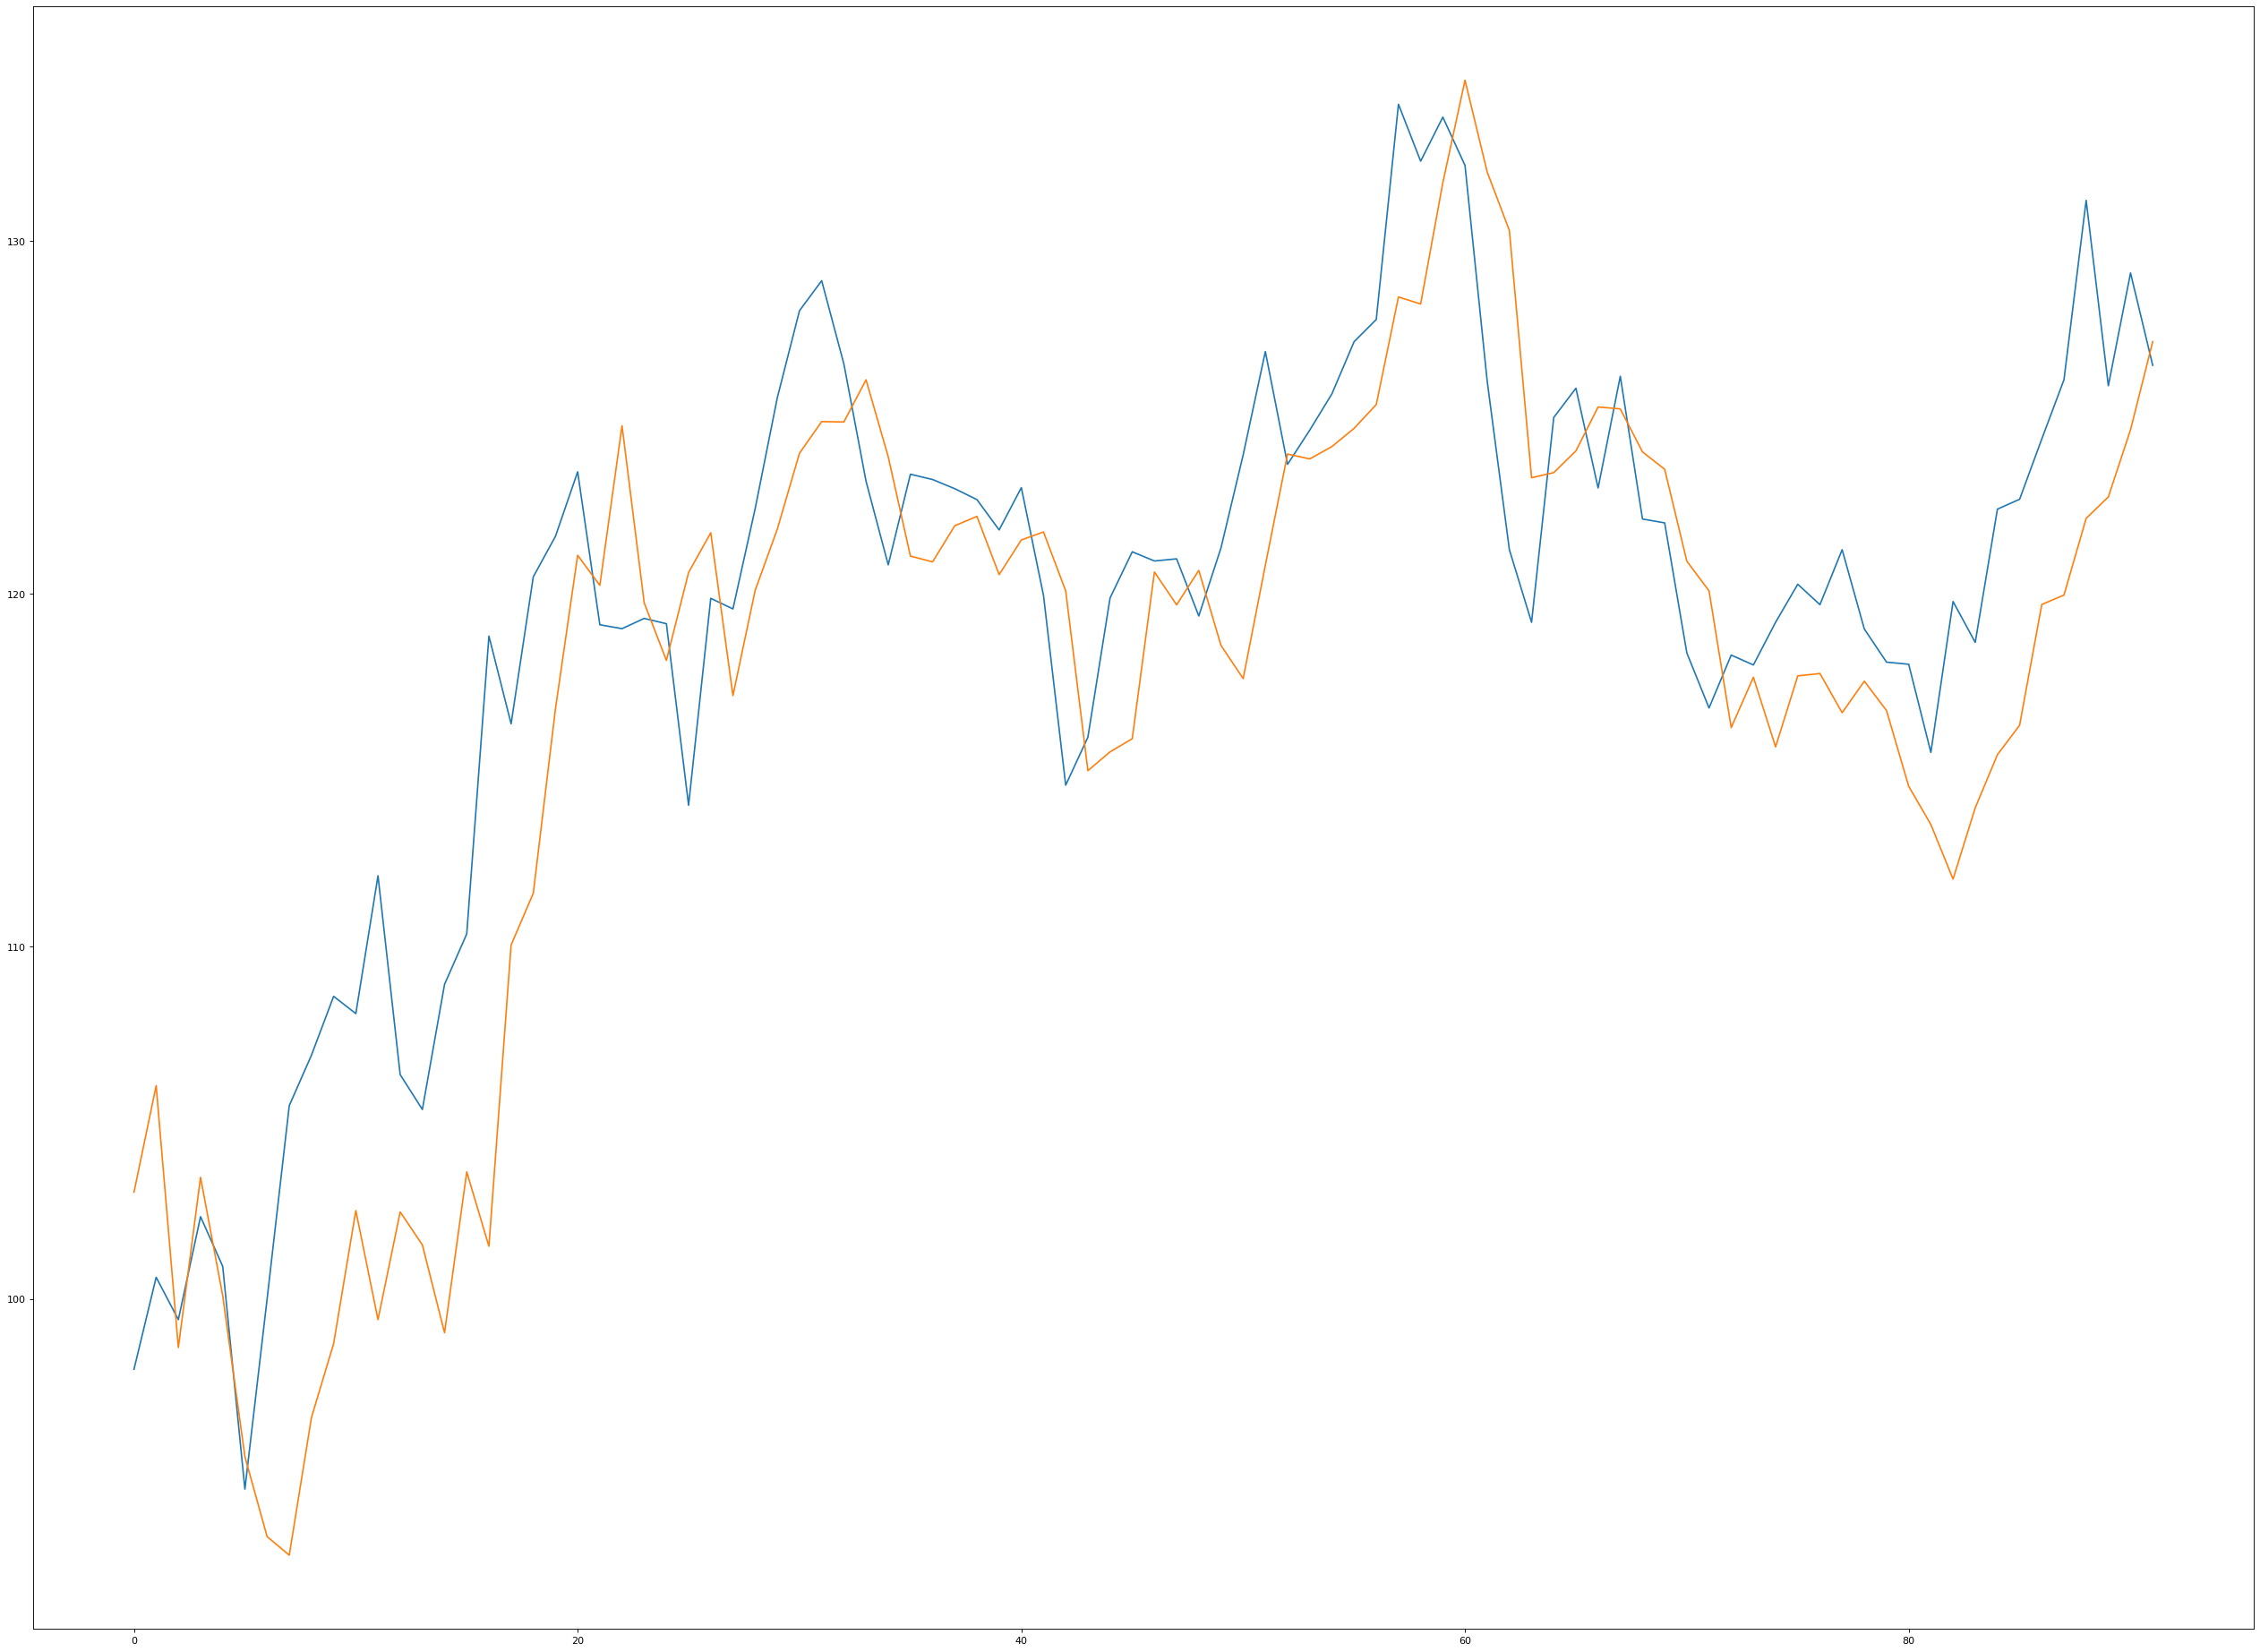

In [33]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), true_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()

##### Last 8 days + prediction of last 4 days

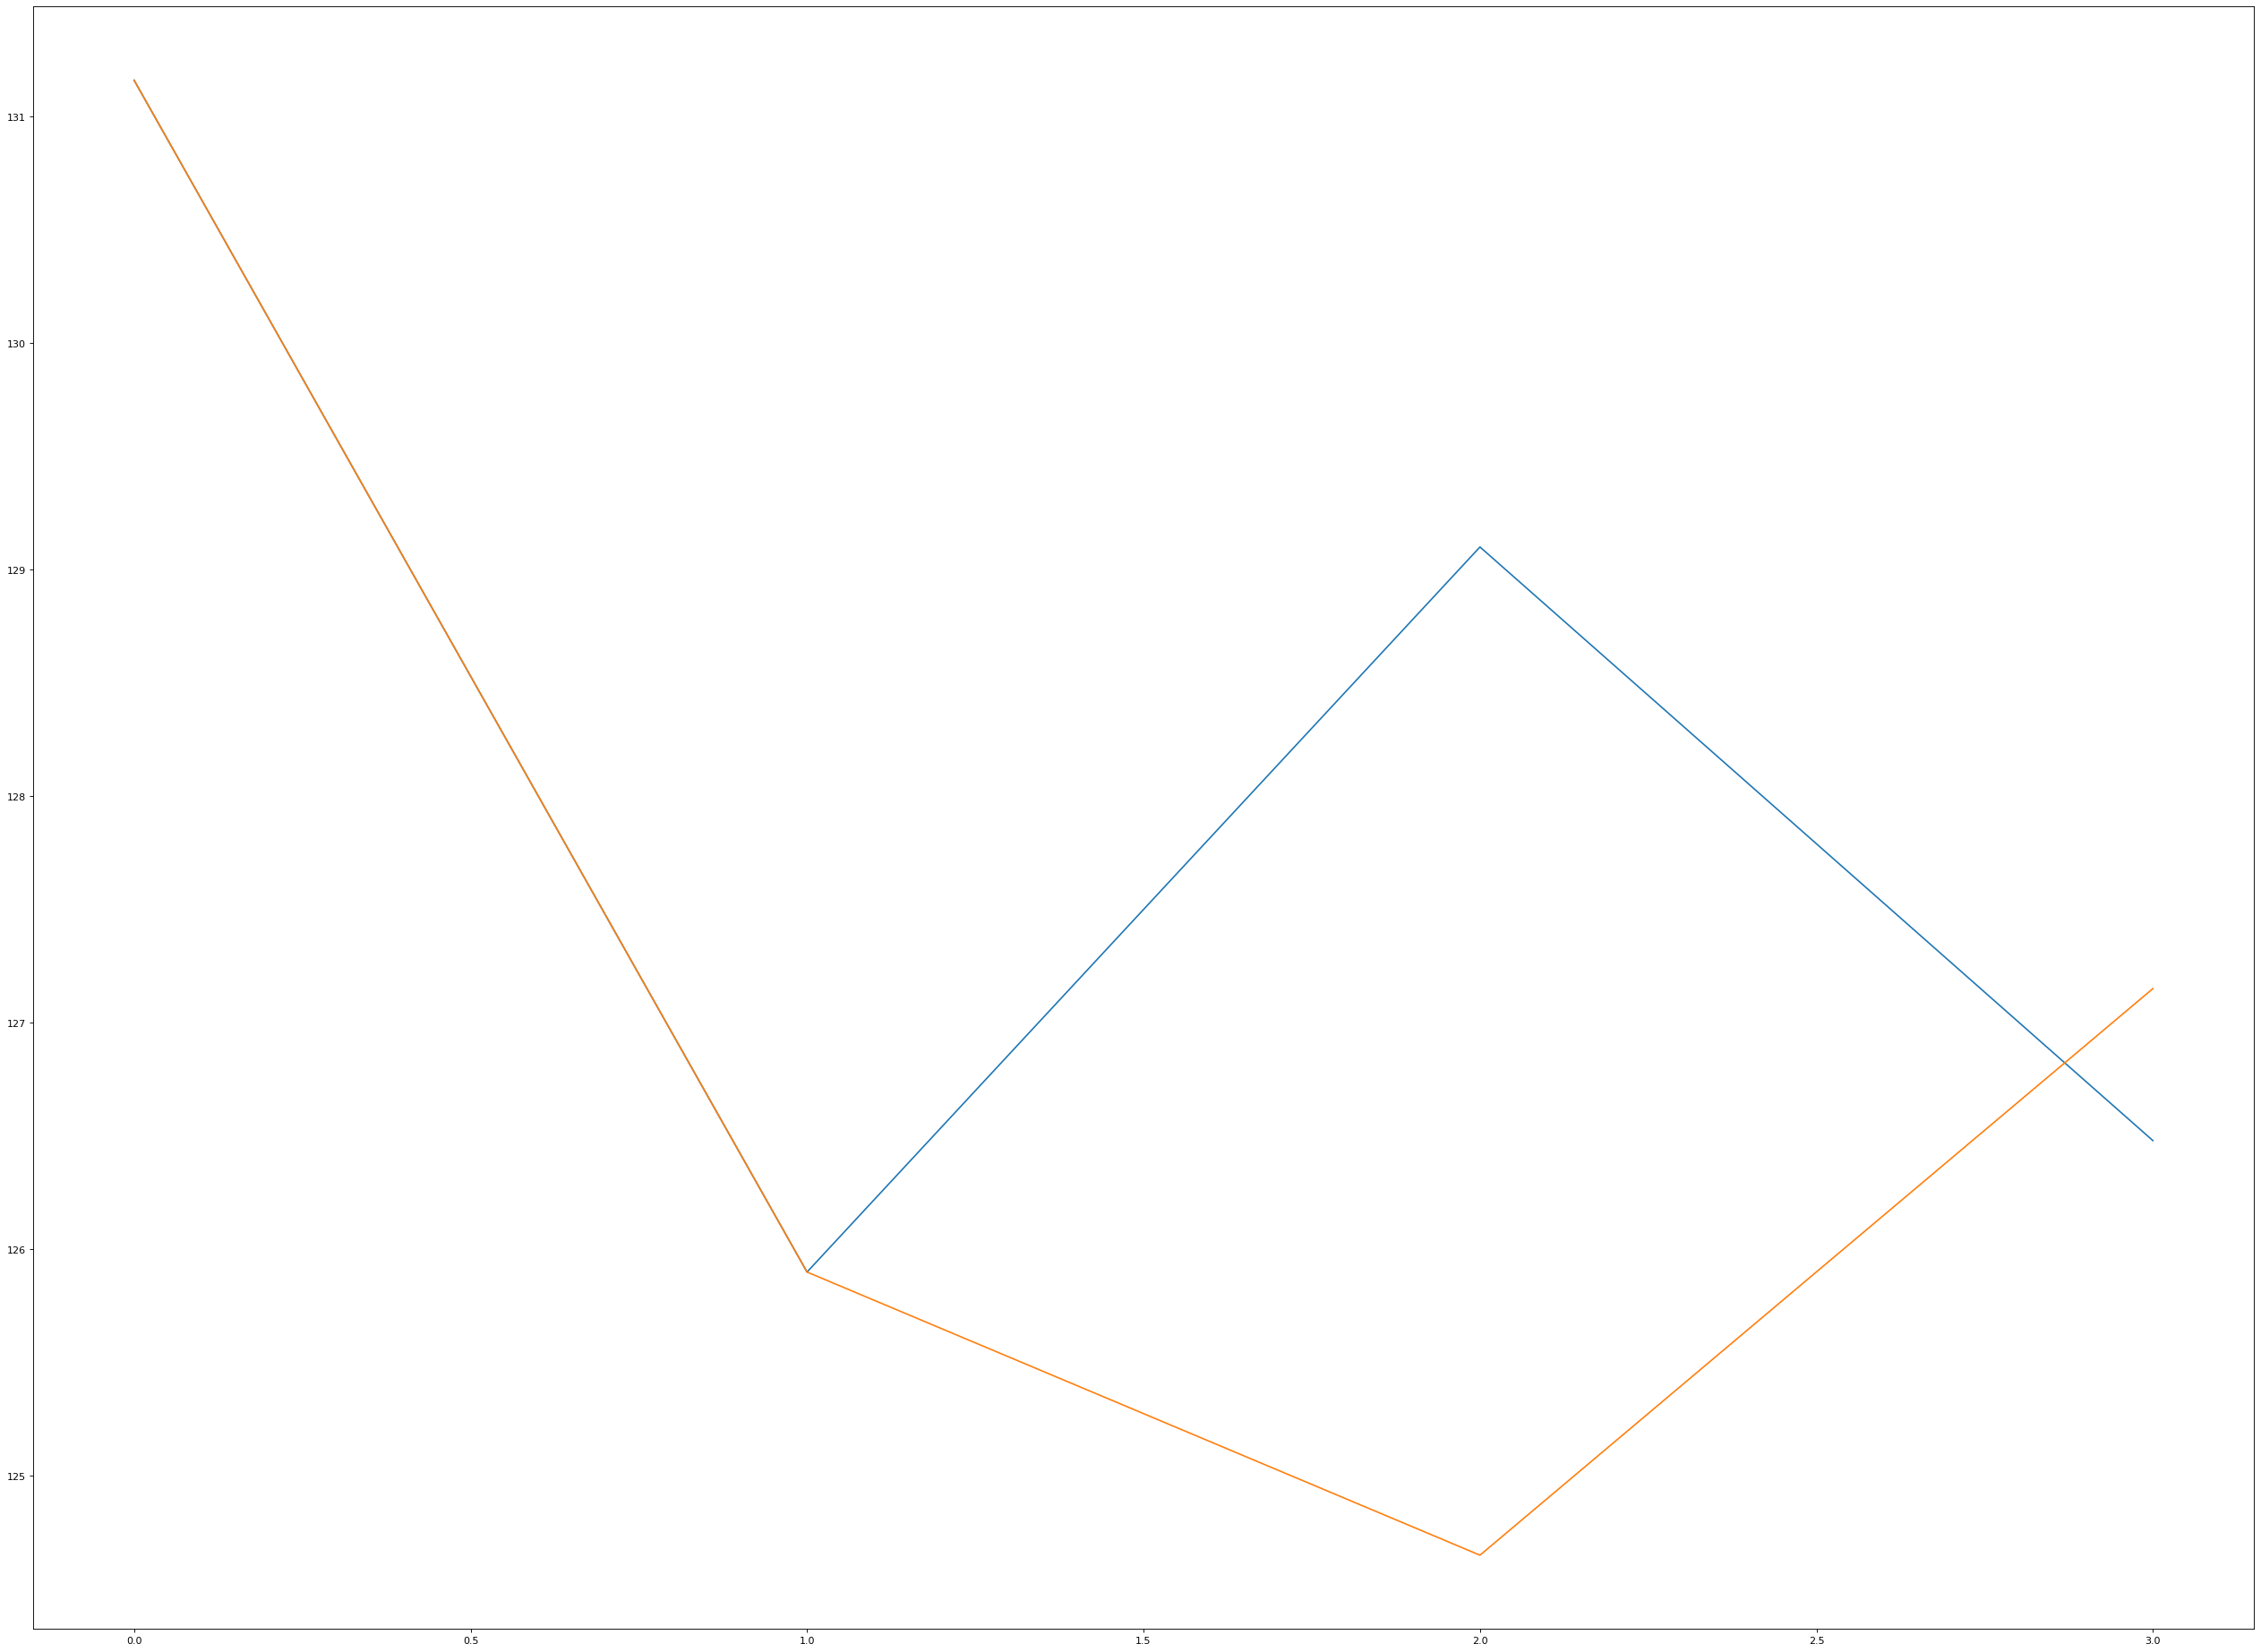

In [38]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(8), true_y_test[-8:])
plt.plot(range(8), np.append(true_y_test[-8:-4], predicted_y_test[-4:]))
plt.show()